# Napelem termelés előrejelzés

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,explained_variance_score
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso,ElasticNet,Ridge,LinearRegression
from sklearn.svm import SVR,LinearSVR

pd.options.mode.chained_assignment = None
%matplotlib inline

Beolvastam a teljes adathalmazt és összekapcsoltam a magyarázó változókkal

In [108]:
# Reading the data
PATH_TO_TRAIN = '../data/raw/train15.csv'
PATH_TO_PREDICTORS = '../data/raw/predictors15.csv'
INDEX_COLUMN = 'TIMESTAMP'
TARGET_COLUMN = 'POWER'
df_power = pd.read_csv(PATH_TO_TRAIN)
df_features = pd.read_csv(PATH_TO_PREDICTORS)
df_original = df_power.merge(df_features, how='left', on=[INDEX_COLUMN,'ZONEID'])

Megnéztem, hogy néz ki az adat.

In [109]:
df_original.describe()

,ZONEID,POWER,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228
count,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,5.695200e+04,5.695200e+04,5.695200e+04,56952.000000
mean,2.000000,0.186872,0.041470,0.016408,93807.236996,67.610793,0.436522,0.738276,-0.257701,285.435328,1.250545e+07,1.382187e+07,1.462089e+07,0.000997
std,0.816504,0.274926,0.122040,0.050371,1106.902058,20.336232,0.400015,2.452712,1.983266,7.051843,6.593117e+06,7.755640e+06,7.049271e+06,0.003445
min,1.000000,0.000000,0.000000,0.000000,90345.875000,6.348233,0.000000,-8.908603,-8.404230,269.436279,1.147127e+05,8.216176e+05,6.465230e+05,0.000000
25%,1.000000,0.000000,0.000000,0.000000,92903.000000,52.359467,0.012650,-0.775085,-1.594760,280.142761,7.616334e+06,7.271122e+06,9.568199e+06,0.000000
50%,2.000000,0.003117,0.002919,0.000117,94008.093750,70.545609,0.353457,0.368076,-0.411445,284.784790,1.141026e+07,1.368581e+07,1.342308e+07,0.000000
75%,3.000000,0.333608,0.033479,0.007191,94668.203125,84.952175,0.884594,2.143609,0.944802,290.000977,1.742018e+07,2.002196e+07,2.002346e+07,0.000257
max,3.000000,1.003550,4.103422,0.820470,96317.125000,102.838364,1.000008,13.056718,10.710998,310.458496,3.462558e+07,3.467366e+07,3.772200e+07,0.055961


In [110]:
df_original.head()

,ZONEID,TIMESTAMP,POWER,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228
0,1,20120401 01:00,0.754103,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2577830.0,1202532.0,2861797.0,0.000000
1,1,20120401 02:00,0.555000,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5356093.0,2446757.0,5949378.0,0.000000
2,1,20120401 03:00,0.438397,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7921788.0,3681336.0,8939176.0,0.001341
3,1,20120401 04:00,0.145449,0.057167,0.110645,94704.0625,67.775284,0.965866,3.106102,-1.446051,293.261475,9860520.0,4921504.0,11331679.0,0.002501
4,1,20120401 05:00,0.111987,0.051027,0.189560,94675.0000,70.172989,0.944669,2.601146,-1.904493,292.732910,11143097.0,6254380.0,13105558.0,0.003331


In [111]:
 df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56952 entries, 0 to 56951
Data columns (total 15 columns):
ZONEID       56952 non-null int64
TIMESTAMP    56952 non-null object
POWER        56952 non-null float64
VAR78        56952 non-null float64
VAR79        56952 non-null float64
VAR134       56952 non-null float64
VAR157       56952 non-null float64
VAR164       56952 non-null float64
VAR165       56952 non-null float64
VAR166       56952 non-null float64
VAR167       56952 non-null float64
VAR169       56952 non-null float64
VAR175       56952 non-null float64
VAR178       56952 non-null float64
VAR228       56952 non-null float64
dtypes: float64(13), int64(1), object(1)
memory usage: 7.0+ MB


A fentiekből kiolvasva látsztik, hogy a timestamp nem dateTime típusú, illetve az is hogy milyen formátumban van. Ezek alapján át lehet konvertálni. Ami még látszik belőle, hogy az egyes mérési eredmények óránként vannak megadva.

In [112]:
df = df_original.copy()
df

,ZONEID,TIMESTAMP,POWER,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228
0,1,20120401 01:00,0.754103,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2.577830e+06,1202532.0,2861797.0,0.000000
1,1,20120401 02:00,0.555000,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5.356093e+06,2446757.0,5949378.0,0.000000
2,1,20120401 03:00,0.438397,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7.921788e+06,3681336.0,8939176.0,0.001341
3,1,20120401 04:00,0.145449,0.057167,0.110645,94704.0625,67.775284,0.965866,3.106102,-1.446051,293.261475,9.860520e+06,4921504.0,11331679.0,0.002501
4,1,20120401 05:00,0.111987,0.051027,0.189560,94675.0000,70.172989,0.944669,2.601146,-1.904493,292.732910,1.114310e+07,6254380.0,13105558.0,0.003331
5,1,20120401 06:00,0.057244,0.036996,0.099045,94676.9375,72.374039,0.641353,1.333368,-1.728431,292.077148,1.181577e+07,7558415.0,14198503.0,0.003960
6,1,20120401 07:00,0.088718,0.080911,0.121323,94708.0625,81.798737,0.753142,1.457923,-1.034620,291.069336,1.227459e+07,8798617.0,14925342.0,0.004970
7,1,20120401 08:00,0.030064,0.036159,0.139069,94748.8125,87.854065,0.788338,2.374826,-1.089040,289.073486,1.235129e+07,10041167.0,15112951.0,0.006477
8,1,20120401 09:00,0.000128,0.036372,0.072609,94785.8125,88.793488,0.502275,1.985531,-0.963010,288.031250,1.235129e+07,11257316.0,15112951.0,0.006725
9,1,20120401 10:00,0.000000,0.014353,0.035797,94817.7500,90.450668,0.501918,1.999518,-0.930320,287.405762,1.235129e+07,12460132.0,15112951.0,0.006745


In [113]:
DATE_FORMAT = '%Y%m%d %H:%M'
dateparse = lambda x: pd.datetime.strptime(x, DATE_FORMAT)
df[INDEX_COLUMN] = df[INDEX_COLUMN].apply(dateparse)

In [114]:
df[INDEX_COLUMN].head(1)

0   2012-04-01 01:00:00
Name: TIMESTAMP, dtype: datetime64[ns]

Amit még érdemes átalakítani , az a feature változók elnevezése. VARXY elég nehezen értelmezhető, ezért átneveztem őket a feladaleírásban szereplő nevekkel.

In [115]:
column_mapping = {"VAR78":"LIQUID_WATER", "VAR79": "ICE_WATER",  "VAR134":"SURFACE_PRESSURE","VAR157":"RELATIVE_HUMIDITY","VAR164":"TOTAL_CLOUD_COVER","VAR165":"WIND_U","VAR166":"WIND_V","VAR167":"TEMPERATURE","VAR169":"SOLAR_RAD","VAR175":"TERMAL_RAD","VAR178":"TOP_NET_SOLAR_RAD","VAR228":"TOTAL_PRECIPATION"}
df = df.rename(index=str, columns=column_mapping)
print(df.columns)

Index(['ZONEID', 'TIMESTAMP', 'POWER', 'LIQUID_WATER', 'ICE_WATER',
       'SURFACE_PRESSURE', 'RELATIVE_HUMIDITY', 'TOTAL_CLOUD_COVER', 'WIND_U',
       'WIND_V', 'TEMPERATURE', 'SOLAR_RAD', 'TERMAL_RAD', 'TOP_NET_SOLAR_RAD',
       'TOTAL_PRECIPATION'],
      dtype='object')


Megnéztem zónánként milyen az eloszlása a célváltozónak

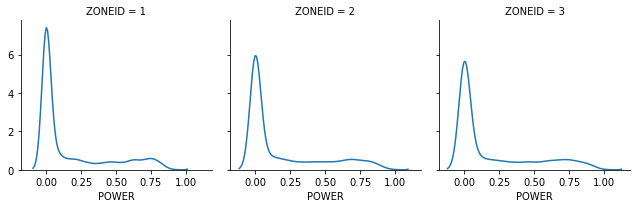

In [116]:
g = sns.FacetGrid(df, col="ZONEID")
g.map(sns.kdeplot, TARGET_COLUMN)

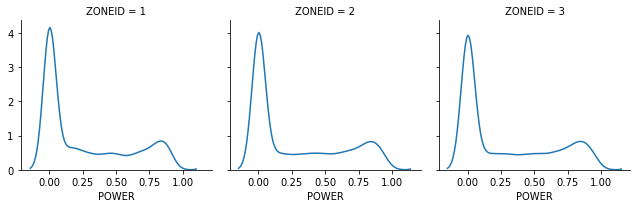

In [117]:
import numpy as np
df_new = df.copy()
df_new["POWER"] = df_new["POWER"].apply(lambda x:np.sqrt(x))
g = sns.FacetGrid(df_new , col="ZONEID")
g.map(sns.kdeplot, TARGET_COLUMN)

In [118]:
df["POWER"] =df["POWER"].apply(lambda x:np.power(x,2))

Mivel nagyjából egyformának tűnik, azt leszámítva, hogy az első zónában kicsit több érték van a 0 közelében, így úgy döntöttem az elemzési részben elég csak egyet vizsgálnom közülük első körben. Modell építésnél is szerintem külön modellt fogok rájuk építeni.

In [119]:
df = df[df.ZONEID == 1].drop('ZONEID',axis=1)
#df2 = df[df.ZONEID == 2].drop('ZONEID',axis=1)
#df3 = df[df.ZONEID == 3].drop('ZONEID',axis=1)

A továbbiakban felveszem a timestampet indexnek hogy a megjelítésnél jobban látszon a célváltozó időbeli változása.

In [120]:
df = df.set_index(INDEX_COLUMN)

Mivel óránkénti adatunk van, ezért az alábbi módon tudjuk definiálni, a hónapot, hetet, évet.

In [121]:
ONE_DAY = 24
ONE_WEEK = 7 * ONE_DAY
ONE_MONTH = 30 * ONE_DAY
ONE_YEAR = 365 * ONE_DAY

Megnéztem napi, illetve heti szinten hogyan változik a célváltozó, ebből az látszik, hogy van egy napi szintű szezonalitása a célváltozónak

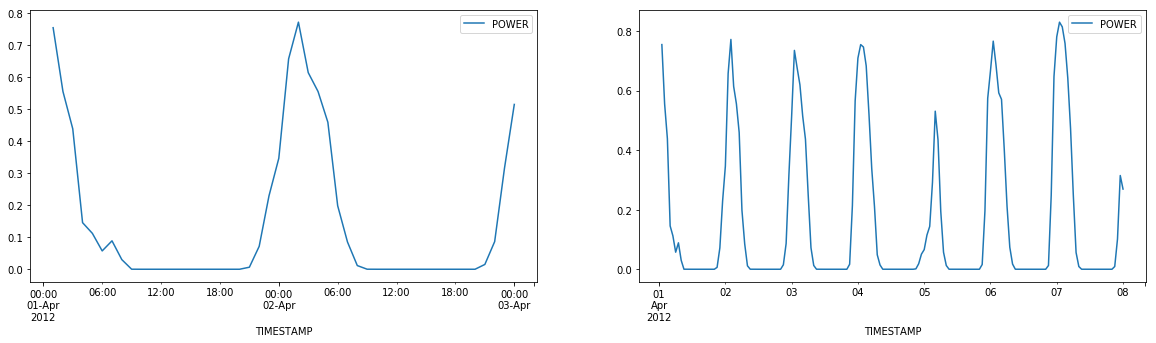

In [122]:
df["POWER"] = df["POWER"].apply(lambda x: np.sqrt(x))
fig, ax = plt.subplots(1,2,figsize=(20,10))
df[:2*ONE_DAY].plot(y=TARGET_COLUMN,ax=ax[0])
df[:ONE_WEEK].plot(y=TARGET_COLUMN,figsize=(20,5),ax=ax[1])

0.02368518624202189


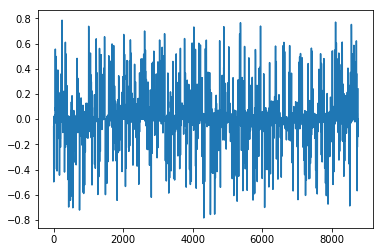

In [123]:
import pylab
import numpy as np


time_division_inputs_1 = []
time_division_inputs_2 = []
for i in range(1):
    time_division_inputs_1.extend(df[i*ONE_YEAR:(i+1)*ONE_YEAR][TARGET_COLUMN].values)
    time_division_inputs_2.extend(df[(i+1)*ONE_YEAR:(i+2)*ONE_YEAR][TARGET_COLUMN].values)
#data_array_original = np.fft.fft(pylab.array(time_division_inputs_1))
#data_array = np.fft.fft(pylab.array(time_division_inputs_2))
#pylab.plot(time_division_inputs_1-time_division_inputs_2)
#pylab.show()
print(mean_squared_error(time_division_inputs_1,time_division_inputs_2))
pylab.plot(np.asarray(time_division_inputs_1)-np.asarray(time_division_inputs_2))
pylab.show()

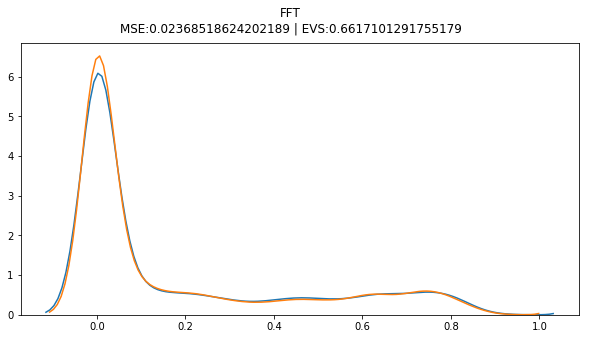

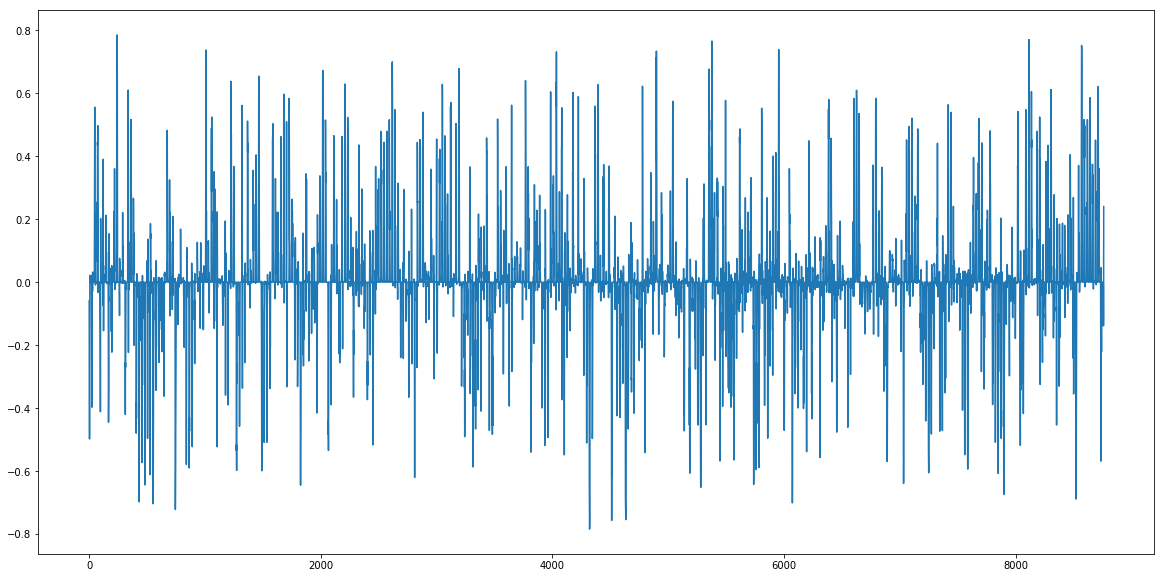

In [124]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("{0}\nMSE:{1} | EVS:{2}".format("FFT",mean_squared_error(time_division_inputs_1,time_division_inputs_2),explained_variance_score(time_division_inputs_1,time_division_inputs_2)), fontsize=12)
sns.kdeplot(time_division_inputs_1)
sns.kdeplot(time_division_inputs_2)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.array(time_division_inputs_1)-np.array(time_division_inputs_2))

Ez után megnéztem, ha más felbontásban nézem az adatot (napi/havi/fél éves), akkor milyen mintát lehet benne felfedezni.

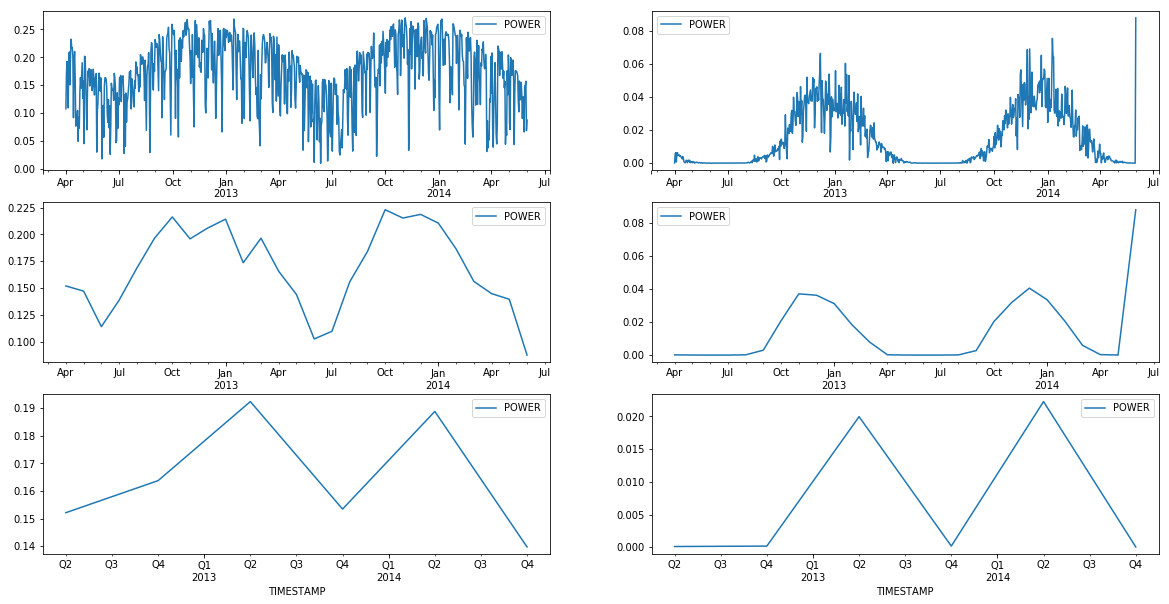

In [125]:
power_by_day = df.resample('D')
power_by_month = df.resample('M')
power_by_semester = df.resample('6M')

fig, ax = plt.subplots(3,2,figsize=(20,10))

power_by_day.mean().plot(y='POWER',ax = ax[0][0])
power_by_day.median().plot(y='POWER', ax =ax[0][1])
power_by_month.mean().plot(y='POWER', ax =ax[1][0])
power_by_month.median().plot(y='POWER', ax =ax[1][1])
power_by_semester.mean().plot(y='POWER', ax =ax[2][0])
power_by_semester.median().plot(y='POWER', ax =ax[2][1])

Innen az látszik, hogy a napi szezonalitáson kívül, van egy éves szezonalitása is. Ez elég magától értetődő, ha jobban belegondolunk, mivel napelemek termelését nézzük, ez főleg a napsugárzástól függ. Így a napi szezonalitás magyarázható azzal, hogy van este és nappal, az éves pedig azzal hogy télen kevesebbet és gyengébben süt a nap, mint nyáron.

A következőekben az adat stacionárius jellegát vizsgálom, adott felbontásokra.

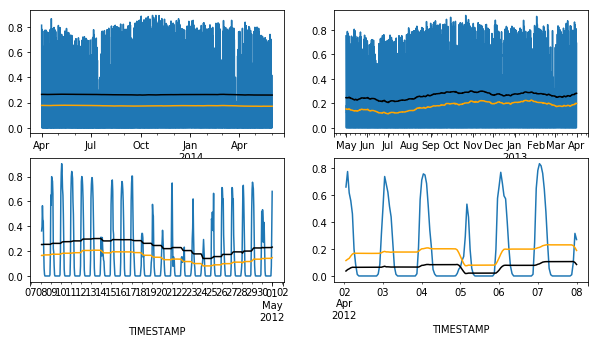

In [126]:
fig, ax = plt.subplots(2,2,figsize=(10,5))
#power_by_day.sum()["POWER"].plot()
df.POWER[ONE_YEAR:].plot(ax=ax[0][0])
df.POWER.rolling(window=ONE_YEAR).mean()[ONE_YEAR:].plot(color="orange",ax=ax[0][0])
df.POWER.rolling(window=ONE_YEAR).std()[ONE_YEAR:].plot(color="black",ax=ax[0][0])

df.POWER[ONE_MONTH:ONE_YEAR].plot(ax=ax[0][1])
df.POWER.rolling(window=ONE_MONTH).mean()[ONE_MONTH:ONE_YEAR].plot(color="orange",ax=ax[0][1])
df.POWER.rolling(window=ONE_MONTH).std()[ONE_MONTH:ONE_YEAR].plot(color="black",ax=ax[0][1])

df.POWER[ONE_WEEK:ONE_MONTH].plot(ax=ax[1][0])
df.POWER.rolling(window=ONE_WEEK).mean()[ONE_WEEK:ONE_MONTH].plot(color="orange",ax=ax[1][0])
df.POWER.rolling(window=ONE_WEEK).std()[ONE_WEEK:ONE_MONTH].plot(color="black",ax=ax[1][0])

df.POWER[ONE_DAY:ONE_WEEK].plot(ax=ax[1][1])
df.POWER.rolling(window=ONE_DAY).mean()[ONE_DAY:ONE_WEEK].plot(color="orange",ax=ax[1][1])
df.POWER.rolling(window=ONE_DAY).var()[ONE_DAY:ONE_WEEK].plot(color="black",ax=ax[1][1])

Éves szinten nézve stacionárius, más felbontásban kevésbé.

Ezután megvizsgáltam, hogy statisztikailag milyen komponensekből áll az adat.

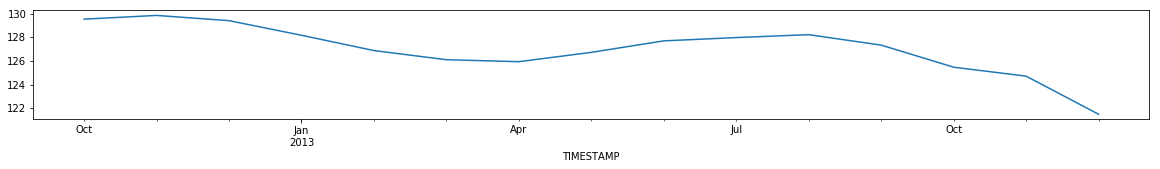

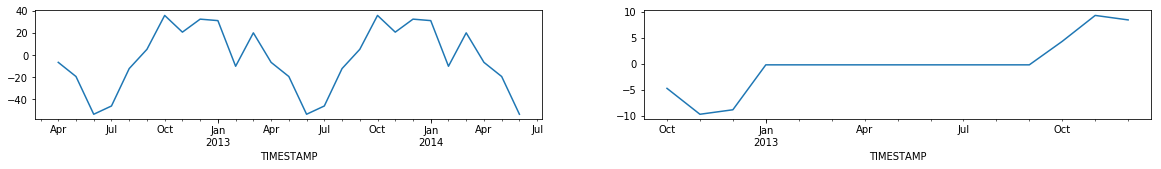

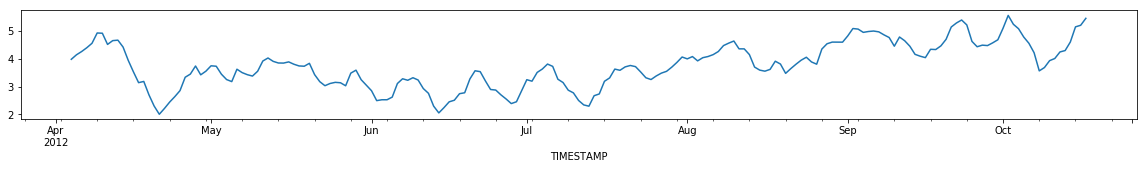

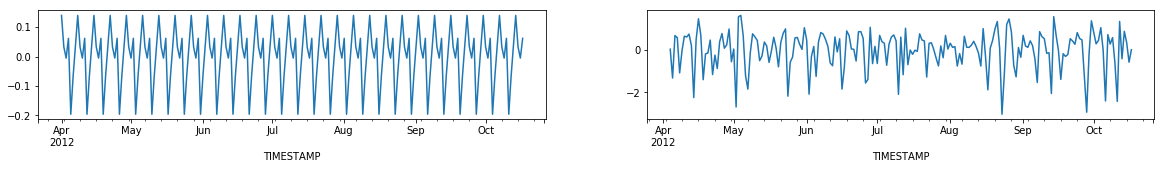

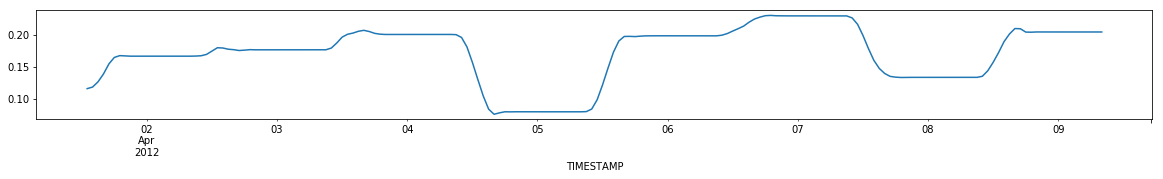

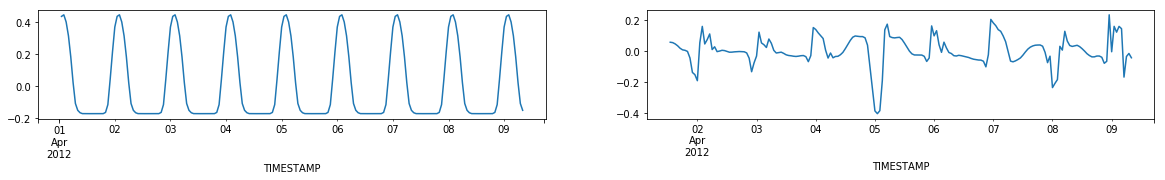

In [87]:

decomposition = seasonal_decompose(power_by_month.sum().POWER)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


fig, ax = plt.subplots(figsize = (20,2))
trend[:200].plot(ax=ax)
fig, ax = plt.subplots(1,2,figsize = (20,2))
seasonality[:200].plot(ax=ax[0])
residual[:200].plot(ax=ax[1])

decomposition = seasonal_decompose(power_by_day.sum().POWER)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


fig, ax = plt.subplots(figsize = (20,2))
trend[:200].plot(ax=ax)
fig, ax = plt.subplots(1,2,figsize = (20,2))
seasonality[:200].plot(ax=ax[0])
residual[:200].plot(ax=ax[1])


decomposition = seasonal_decompose(df.POWER)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


fig, ax = plt.subplots(figsize = (20,2))
trend[:200].plot(ax=ax)
fig, ax = plt.subplots(1,2,figsize = (20,2))
seasonality[:200].plot(ax=ax[0])
residual[:200].plot(ax=ax[1])

Ebből látszik, hogy elég erős a napi szintű szezonalitása. Trendről sok mindent nem lehet megállapítani, illetve főleg azt hogy nincs legalábbis napi szinten nincs.

## Autokorreláció

Ez után megnéztem, hogy milyen a korreláció a termelés mostani és jövő beli értékei között.

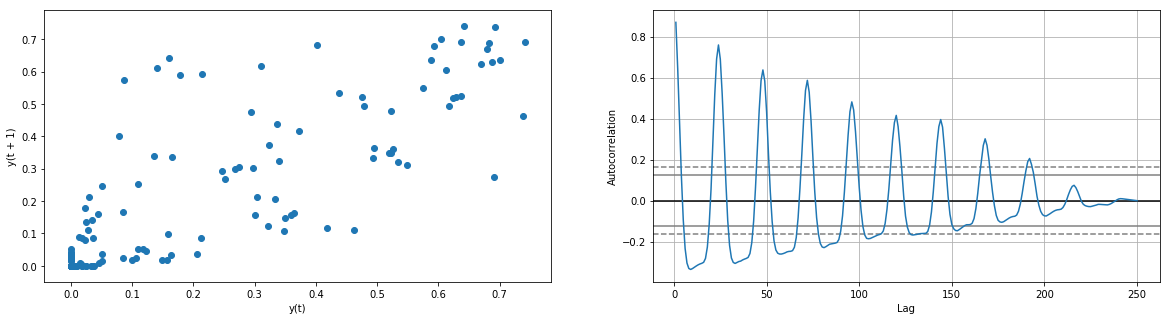

In [88]:
fig, ax = plt.subplots(1,2 ,figsize=(20,5))
lag_plot(df['POWER'].tail(250),ax=ax[0])
autocorrelation_plot(df['POWER'].tail(250),ax=ax[1])

Innen látszik, hogy van kap0csolat a kettő között. A második diagrammról leolvasható, hogy kb. az 50.lag után kezd jelentéktelenebb lenni a kapcsolat, ami 2 napot jelent.

Ez után megnéztem, milyen a kapcsolat komponensenként.

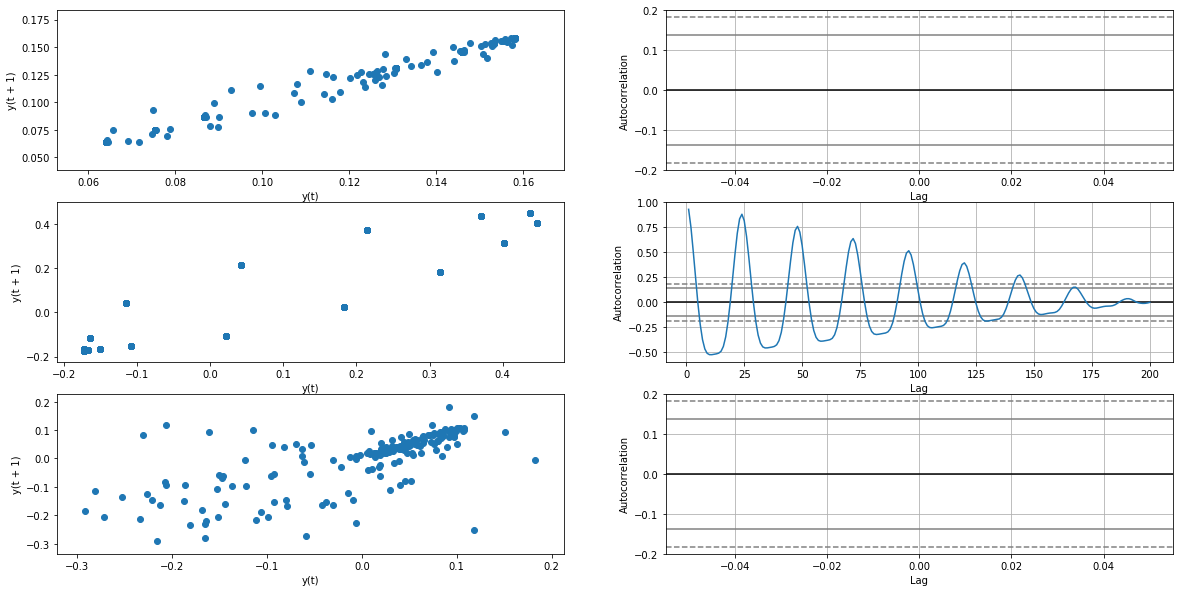

In [89]:
fig, ax = plt.subplots(3,2 ,figsize=(20,10))
lag_plot(trend.tail(200),ax=ax[0][0])
autocorrelation_plot(trend.tail(200),ax=ax[0][1])
lag_plot(seasonality.tail(200),ax=ax[1][0])
autocorrelation_plot(seasonality.tail(200),ax=ax[1][1])
lag_plot(residual.tail(200),ax=ax[2][0])
autocorrelation_plot(residual.tail(200),ax=ax[2][1])

Ebből azt lehet megállapítani, hogy a szezonalitásból ered az erős autokorreláció. Illetve a trendből is megállapítható egyfajta lineáris kapcsolat.

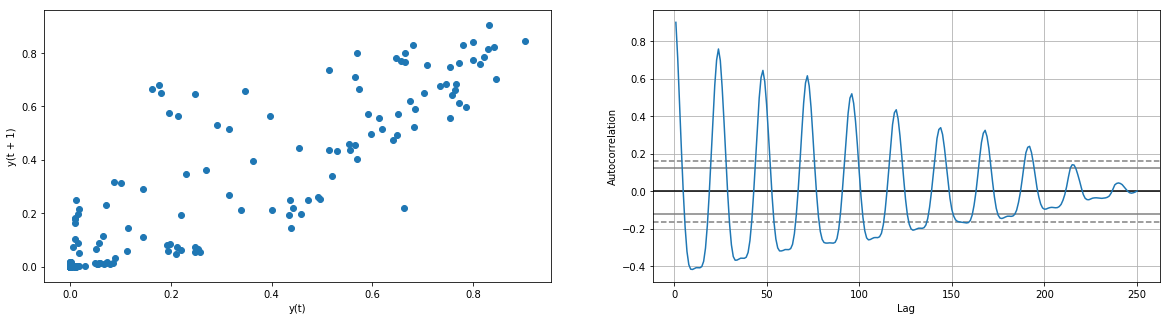

In [90]:
fig, ax = plt.subplots(1,2 ,figsize=(20,5))
lag_plot(df['POWER'].head(250),ax=ax[0])
autocorrelation_plot(df['POWER'].head(250),ax=ax[1])

## Többi feature kapcsolata a célváltozóval

Megnéztem egy két hetes időintervallumra, hogy hogy néznek ki az egyes változók.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000049E516B128>,
      dtype=object)

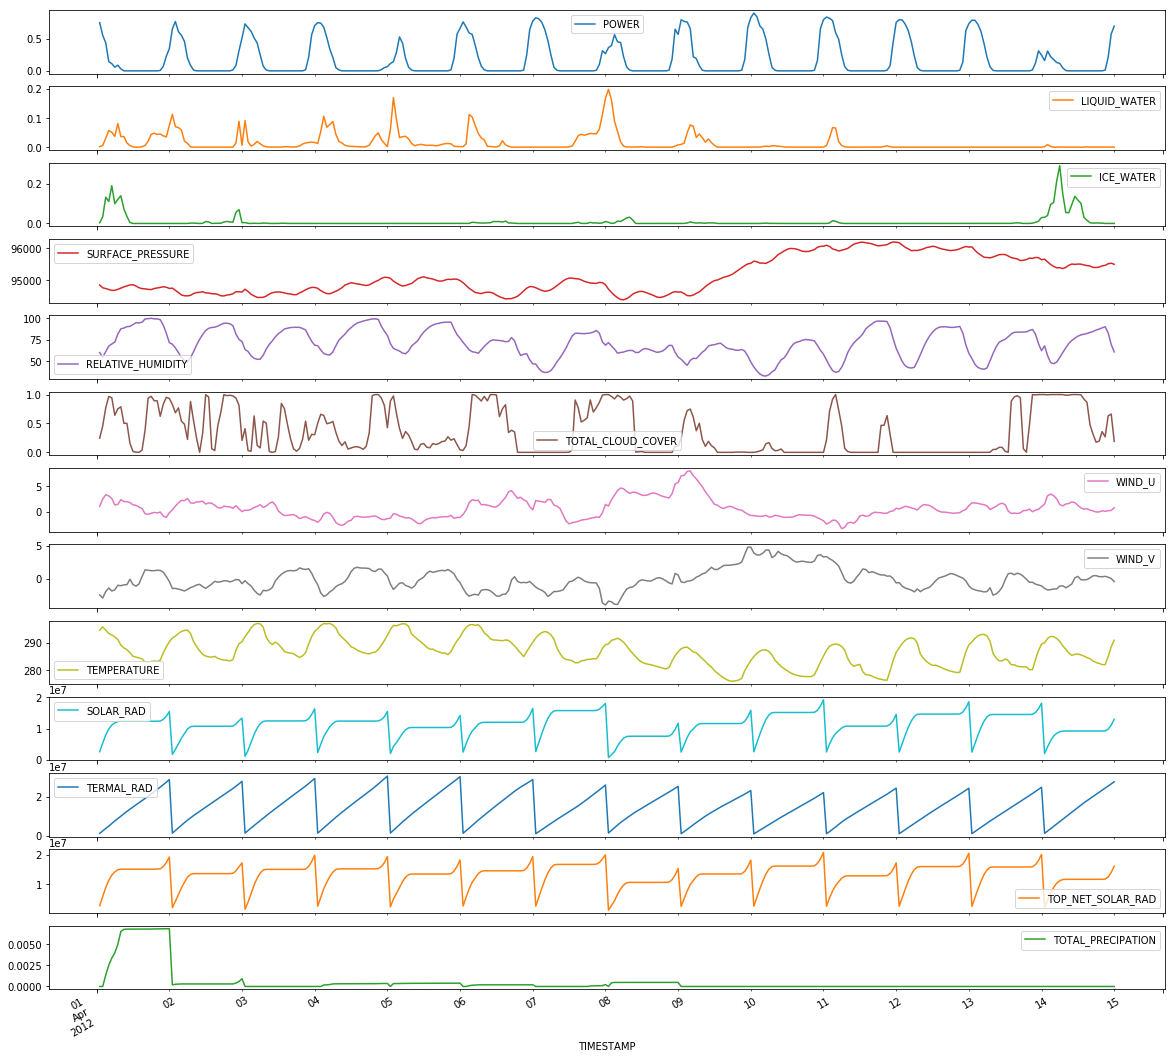

In [91]:
df[:ONE_WEEK*2].plot(subplots=True,figsize=(20,20))

### Ami ebből első ránézésre látszik: 
Ott voltak visszaesések a termelésben, ahol:
* sokat esett az eső
* nagy volt a felhőzet
Ami egész jelentéktelennek tűnik:
* széljárás
* páratartalom
Illetve látszik még, hogy az utolsó négy mező elég furcsán változik, ez azért van, mert ezek akkumlált mezők.

Szétbontottam az akkumlált mezőket.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000049D97DCFD0>,
      dtype=object)

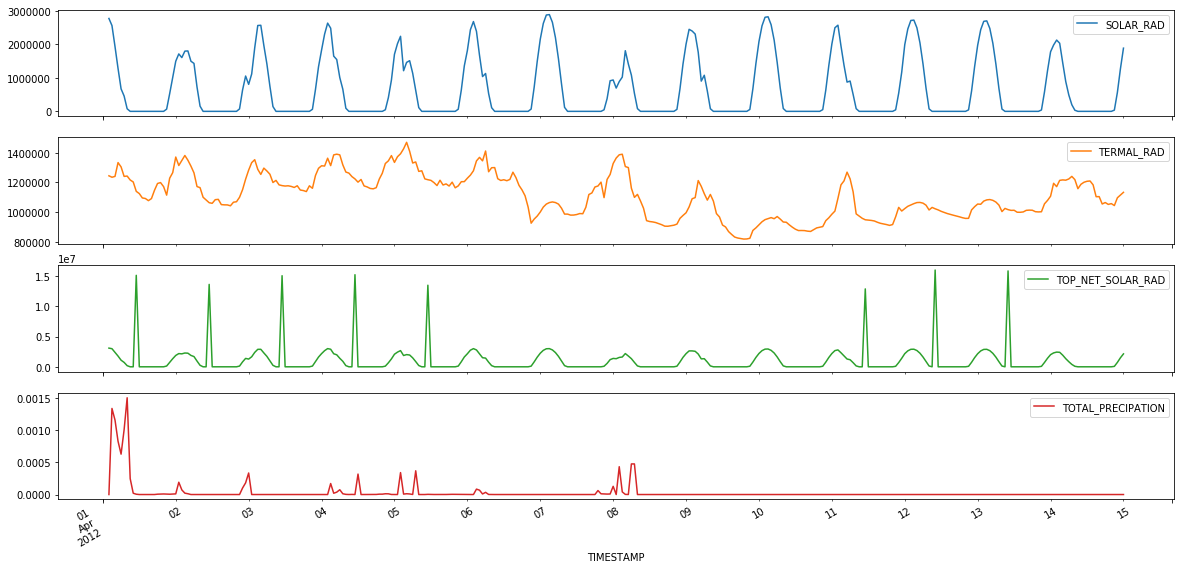

In [92]:
accumlated_columns = ["SOLAR_RAD","TERMAL_RAD","TOP_NET_SOLAR_RAD","TOTAL_PRECIPATION"]
def dissipate_features(df, columns):
    for column in columns:
        df[column] = df[column].rolling(window=2).apply(lambda x: x[1] if x[1] - x[0] < 0 else x[1] - x[0], raw='True')
    return df
df = dissipate_features(df=df, columns=accumlated_columns)
df[:ONE_WEEK*2][accumlated_columns].plot(subplots=True,figsize=(20,10))

In [104]:
def plot_scatters(df, x_columns, target_column):
    number_of_columns = len(x_columns)
    plot_columns = 2
    whole_rows = int(number_of_columns / plot_columns)
    extrarow = 1 if number_of_columns % plot_columns > 0 else 0

    row = -1
    column = 0
    for i, col in enumerate(x_columns):

        last_number_of_columns = number_of_columns%plot_columns
        is_last_row = int(number_of_columns/plot_columns)*plot_columns <= i

        if(i%plot_columns == 0):
            row += 1
            column = 0
            if is_last_row:
                fig, ax = plt.subplots(1,last_number_of_columns,figsize=(20,5))
            else:
                fig, ax = plt.subplots(1,plot_columns,figsize=(20,5))
        else:
            column += 1
        df.plot(x=[col], y=[target_column], kind="scatter", ax = ax[column] )

In [94]:
def plot_boxplots(df):
    number_of_columns = len(df.columns.values)
    plot_columns = 5
    whole_rows = int(number_of_columns / plot_columns)
    extrarow = 1 if number_of_columns % plot_columns > 0 else 0

    row = -1
    column = 0
    for i, col in enumerate(df.columns.values):

        last_number_of_columns = number_of_columns%plot_columns
        is_last_row = int(number_of_columns/plot_columns)*plot_columns <= i

        if(i%plot_columns == 0):
            row += 1
            column = 0
            if is_last_row:
                fig, ax = plt.subplots(1,last_number_of_columns,figsize=(20,4))
            else:
                fig, ax = plt.subplots(1,plot_columns,figsize=(20,4))
        else:
            column += 1
        df[[col]].plot(ax = ax[column], kind='box')

Majd megnéztem milyen kapcsolat van a célváltozó és az egyes változók között.

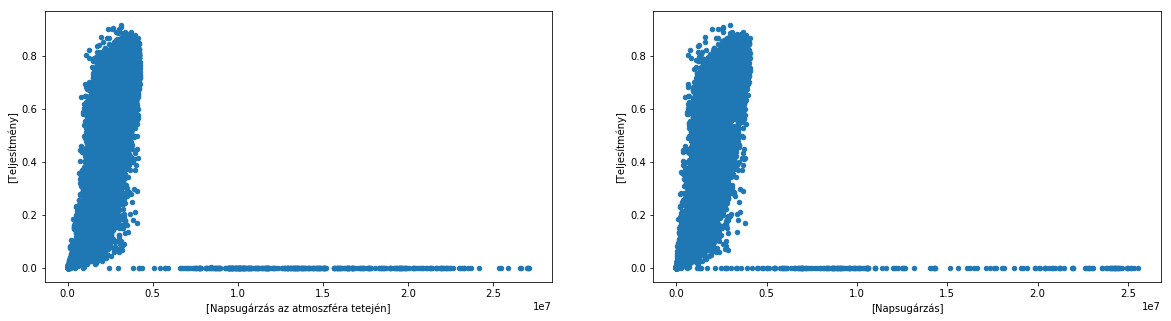

In [105]:
column_mapping = {"TOP_NET_SOLAR_RAD": "Napsugárzás az atmoszféra tetején", "SOLAR_RAD": "Napsugárzás","POWER":"Teljesítmény"}
df = df.rename(index=str,columns=column_mapping)
plot_scatters(df,["Napsugárzás az atmoszféra tetején","Napsugárzás"],"Teljesítmény")

### Amit innen meg tudok állapítani:
* Általában keveset esik az eső, de amikor esik, gyakoribbak az alacsony termelési értékek. Ehhez meg lehetne adni mondjuk egy kategorikus változót, ha egy adott értéknél többet esett az eső.
* A előbbi megállapítás igaz a jég formájú esőre és a teljes csapadékmennyiségre is.
* A napsugárzás mezőkben valószínüleg sok outlier van, mert ilyen magas napsugárzás értékekre 0 termelés elég elképzelhetetlen, de érdemes megnézni, hogy ez milyen időpontokban volt. 

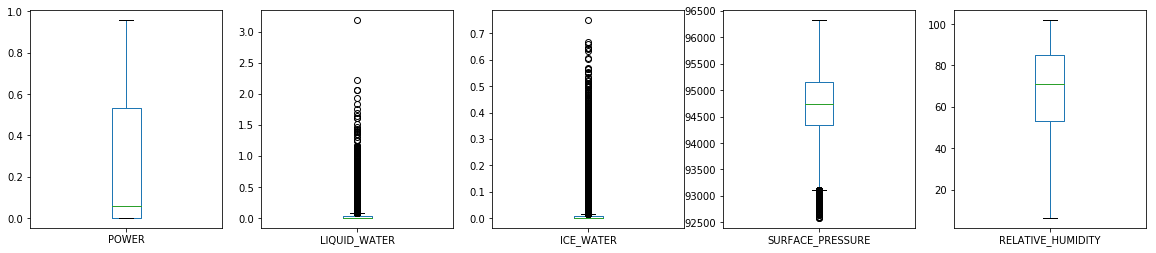

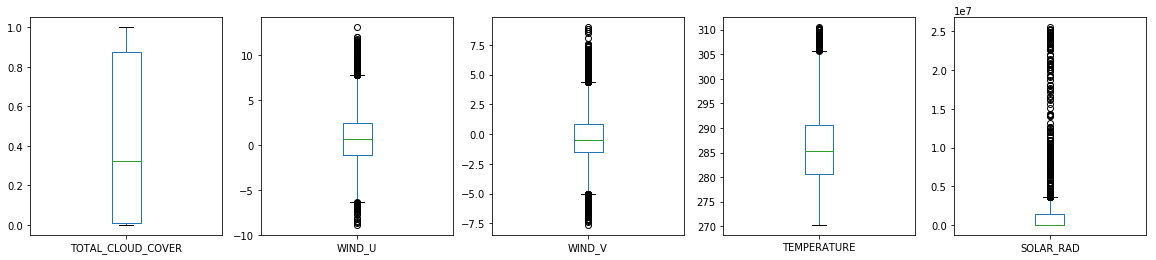

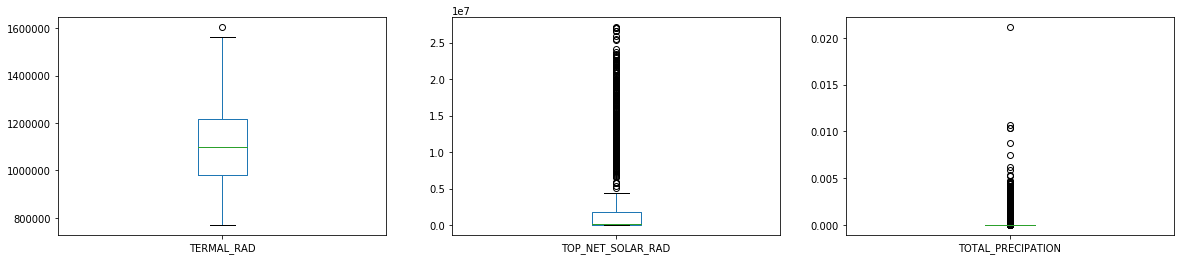

In [35]:
plot_boxplots(df)

Nézzük akkor a magas napsugárzás értékeknél mi történhetett.

Milyen órákban nincs termelés általában

In [36]:
df["HOUR"] = df.index.hour
df["MONTH"] = df.index.month

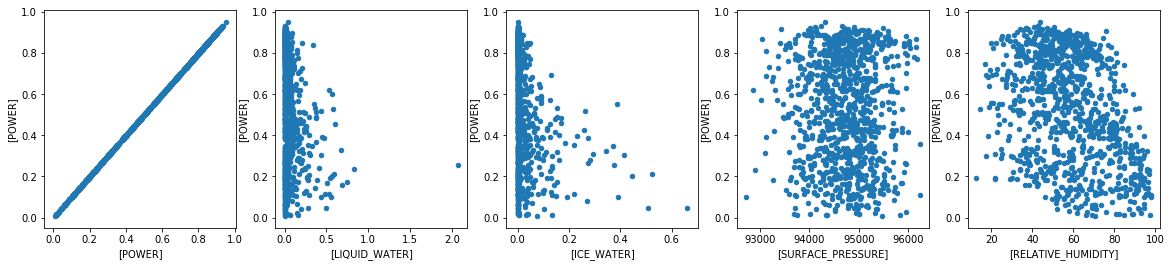

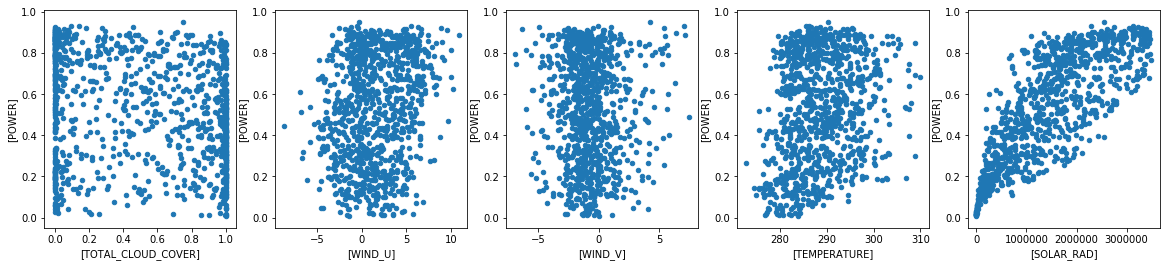

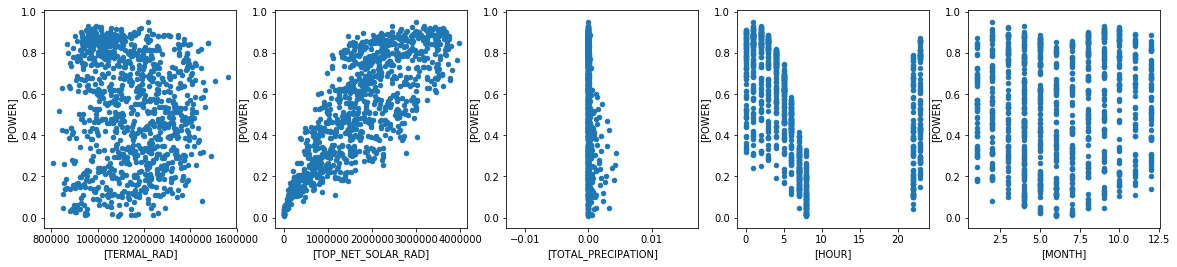

In [37]:
mask = (df["TOP_NET_SOLAR_RAD"]<5000000)  & (df.SOLAR_RAD < 3500000) & (df["HOUR"]<9)  | (df["HOUR"] > 21)
plot_scatters(df[mask].sample(1000),"POWER")

In [38]:
def wind_to_cardinal(u_ms,v_ms):
    wind_abs = np.sqrt(np.power(u_ms,2) + np.power(v_ms,2))
    wind_dir_trig_to = np.arctan2(u_ms/wind_abs, v_ms/wind_abs) 
    wind_dir_trig_to_degrees = wind_dir_trig_to * 180/np.pi ## -111.6 degrees
    wind_dir_trig_from_degrees = wind_dir_trig_to_degrees + 180 ## 68.38 degrees
    wind_dir_cardinal = 90 - wind_dir_trig_from_degrees
    return wind_abs

In [39]:
df["WIND"] = df.apply(lambda x: wind_to_cardinal(x["WIND_U"],x["WIND_V"]),axis=1)

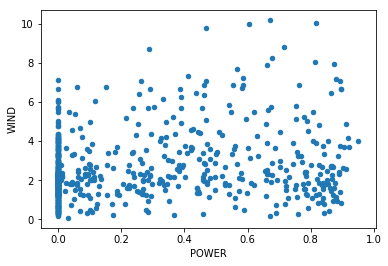

In [40]:
df[:24*30].plot(x='POWER',y='WIND',kind='scatter')

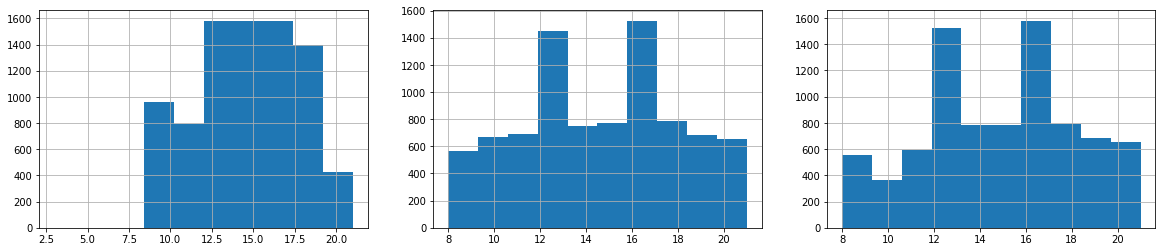

In [41]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
df[df["POWER"] == 0].HOUR.hist(ax = ax[0])
df[df["SOLAR_RAD"] == 0].HOUR.hist(ax = ax[1])
df[df["TOP_NET_SOLAR_RAD"] == 0].HOUR.hist(ax = ax[2])

9 és 21 óra között nincsen termelés leggyakrabban

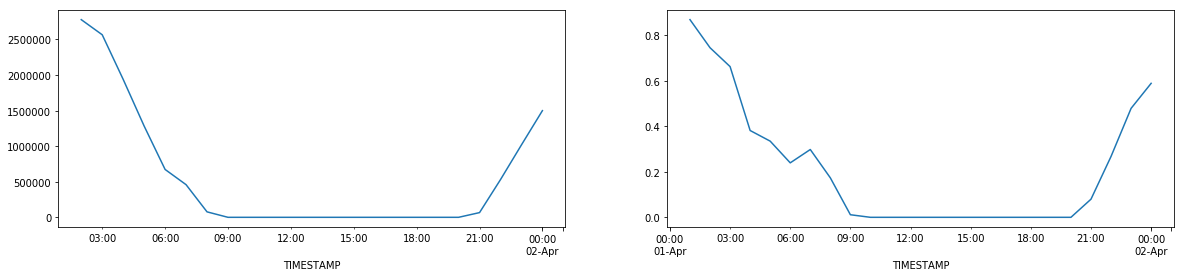

In [42]:
fig, ax = plt.subplots(1,2,figsize=(20,4))
df.SOLAR_RAD[:ONE_DAY].plot(ax=ax[0])
df.POWER[:ONE_DAY].plot(ax=ax[1])

Napsugázásra is igaz, hogy 9 és 21 óra között 0

Nézzük, hogy a legmagasabb napsugárzás milyen időpontokban van.

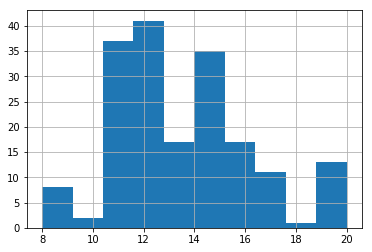

In [43]:
mask = (df["SOLAR_RAD"]>0.5*pow(10,7))
df_outlier = df[mask]
df_outlier["HOUR"] = df_outlier.index.hour
df_outlier["HOUR"].hist()

Ebből az látszik, hogy főleg 11 és 17 között jelenik meg, ami biztos nem jó, mivel akkor van éjszaka.

In [44]:
print("{0} darab értékünk van összesen, ebből {1} darab biztosan outlier.".format(len(df),len(df_outlier)))

18984 darab értékünk van összesen, ebből 182 darab biztosan outlier.


Nézzük máshogy, nézzük 

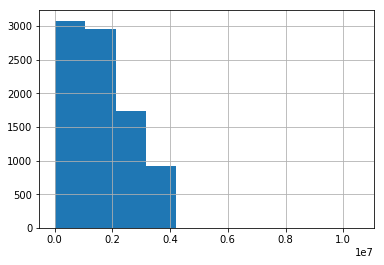

In [45]:
mask = (df["HOUR"]<9)  | (df["HOUR"] > 21)
df[mask]["SOLAR_RAD"].hist()

Ebből, látszik, hogy máshol is van pár irreálisan magas érték.

Felvettem a szezonalitás szerint szétbontott mezőket

In [46]:
df["RESID"] = seasonal_decompose(df.POWER).resid
df["SEASONAL"] = seasonal_decompose(df.POWER).seasonal
df["TREND"] = seasonal_decompose(df.POWER).trend

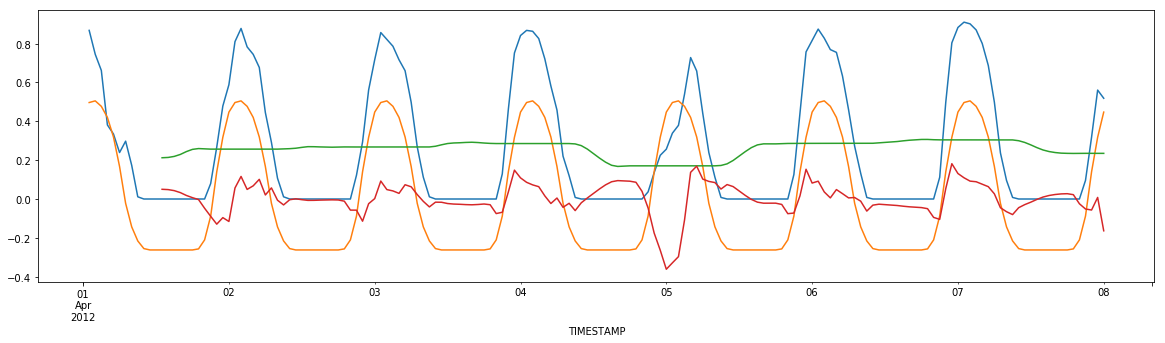

In [47]:
df.POWER[:ONE_WEEK].plot(figsize=(20,5))
df.SEASONAL[:ONE_WEEK].plot(figsize=(20,5))
df.TREND[:ONE_WEEK].plot(figsize=(20,5))
df.RESID[:ONE_WEEK].plot(figsize=(20,5))

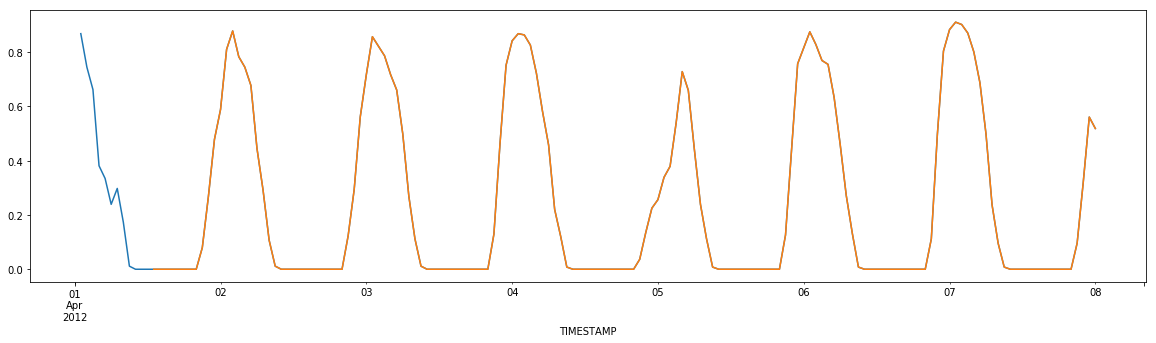

In [48]:
ORIG = df["RESID"]+df["SEASONAL"]+df["TREND"]
df.POWER[:ONE_WEEK].plot(figsize=(20,5))
ORIG[:ONE_WEEK].plot(figsize=(20,5))

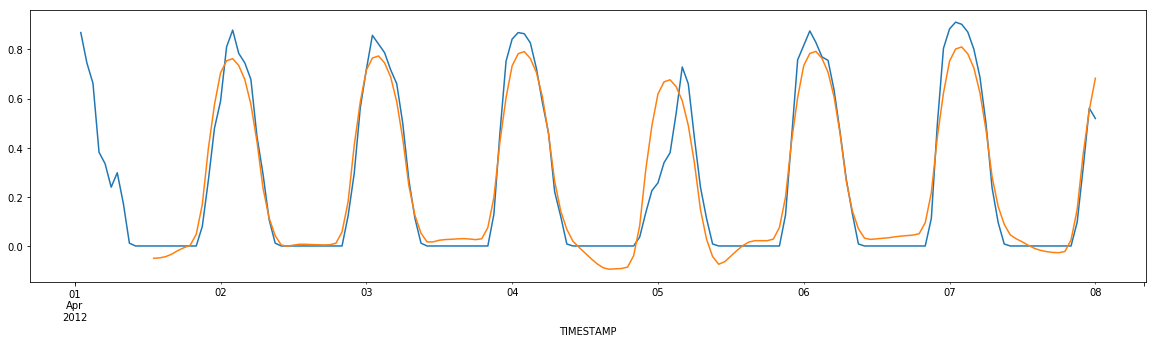

In [49]:
ORIG = df["SEASONAL"]+df["TREND"]
df.POWER[:ONE_WEEK].plot(figsize=(20,5))
ORIG[:ONE_WEEK].plot(figsize=(20,5))

Ebből biztosan látszik, hogy a resid, seasonal és trend mezők összege visszaadja az eredeti függvényt.

Megnéztem a korrelációt az összes mező között

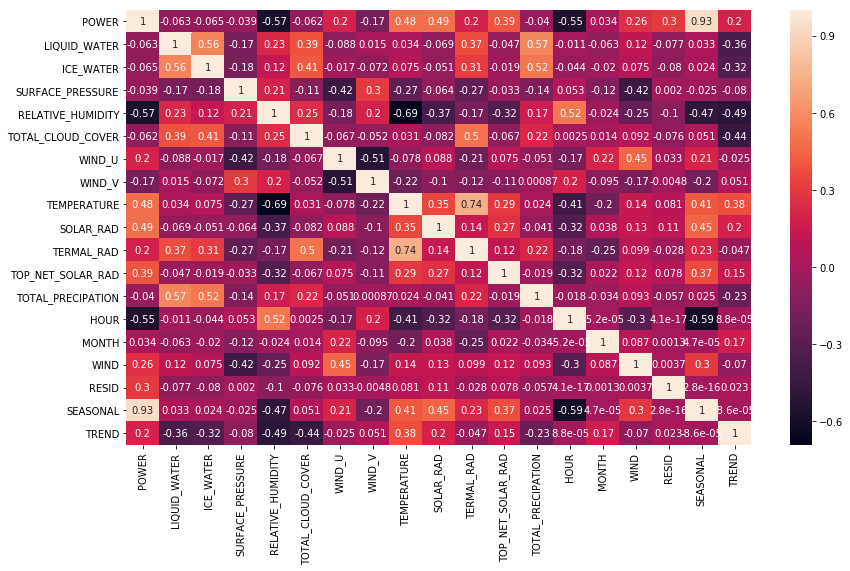

In [50]:
fig, ax = plt.subplots(figsize=(14,8))         # Sample figsize in inches

f = (
    df.loc[:, df.columns]
        
).corr()

sns.heatmap(f, annot=True, ax=ax)

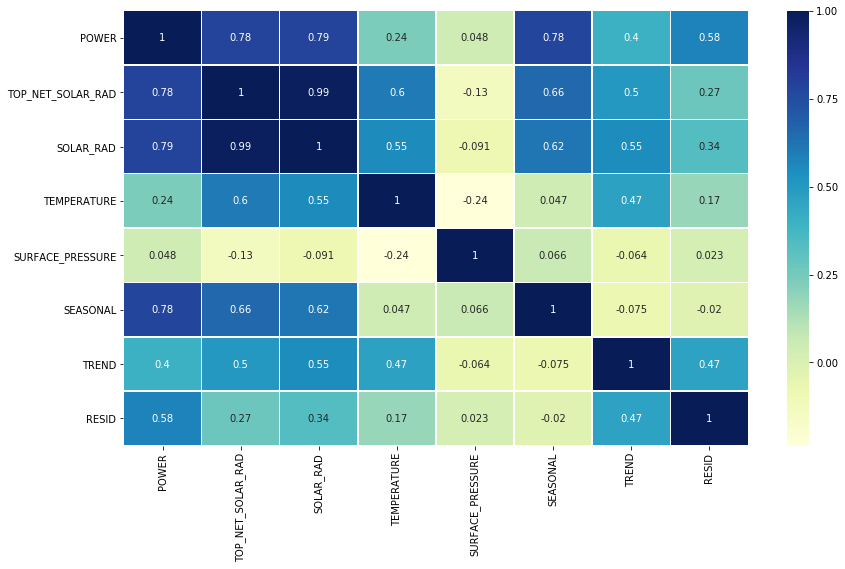

In [51]:
mask = (df["TOP_NET_SOLAR_RAD"]<5000000)  & (df.SOLAR_RAD < 3500000) & (df["HOUR"]<9)  | (df["HOUR"] > 21)
fig, ax = plt.subplots(figsize=(14,8))         # Sample figsize in inches

f = (
    df[mask].loc[:, ['POWER','TOP_NET_SOLAR_RAD','SOLAR_RAD','TEMPERATURE','SURFACE_PRESSURE','SEASONAL','TREND','RESID']]
        
).corr()

sns.heatmap(f, annot=True, ax=ax, linewidths=.5,cmap="YlGnBu")

In [52]:
npc = df[mask].dropna(axis=0)
np.corrcoef([npc.POWER,npc.TOP_NET_SOLAR_RAD,npc.SOLAR_RAD])

array([[1.        , 0.78293238, 0.79149492],
       [0.78293238, 1.        , 0.98544992],
       [0.79149492, 0.98544992, 1.        ]])

In [53]:
# import holoviews as hv
# hv.extension('bokeh')
# from bokeh.sampledata.iris import flowers
# from holoviews.operation import gridmatrix

# ds = hv.Dataset(df[mask])

# grouped_by_species = ds.groupby('HOUR', container_type=hv.NdOverlay)
# grid = gridmatrix(ds, diagonal_type=hv.Scatter)
# grid.options('Scatter', tools=['hover', 'box_select'], bgcolor='#efe8e2', fill_alpha=0.2, size=4)

Innen látszik, hogy az összes eredeti feature közül legjobban a relatív páratartalom, a hőmérsékelet és a napsugárzás korrelálnak a célválztozóval.

Az általam létrehozottak közül pedig a szezonalitás.

Az ötletem az lenne hogy a szezonalitást függvényként tárolom majd, így minden időponthoz kiszámolható. Gépi tanulással pedig a residual és talán a trend komponenseket predictelem.

In [54]:
df["RT"] = df["TREND"] + df["RESID"]

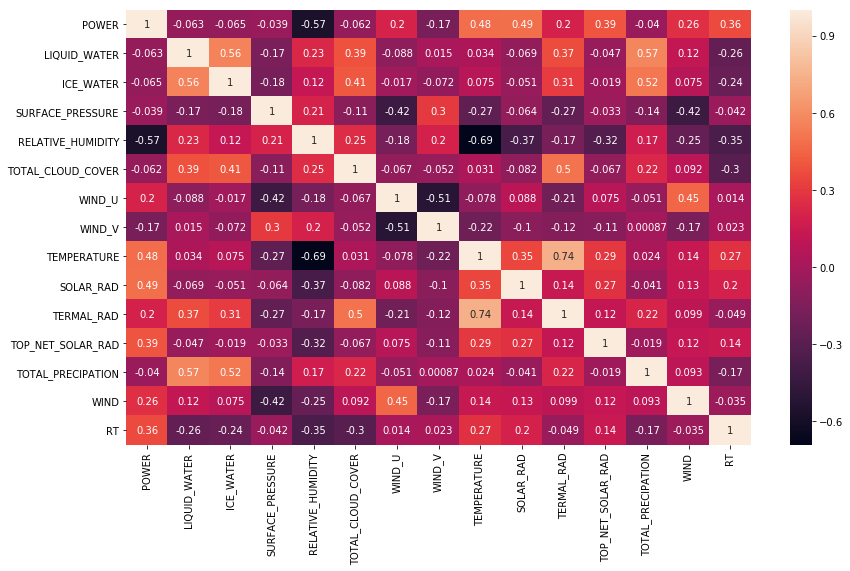

In [55]:
df_to_plot = df.drop(["SEASONAL","HOUR","MONTH","RESID","TREND"],axis=1)
fig, ax = plt.subplots(figsize=(14,8))         # Sample figsize in inches

f = (
    df_to_plot.loc[:, df_to_plot.columns]
        
).corr()

sns.heatmap(f, annot=True, ax=ax)

Relatív páratartalom, napsugárzás és hőmérséklet amik fontosabbak.

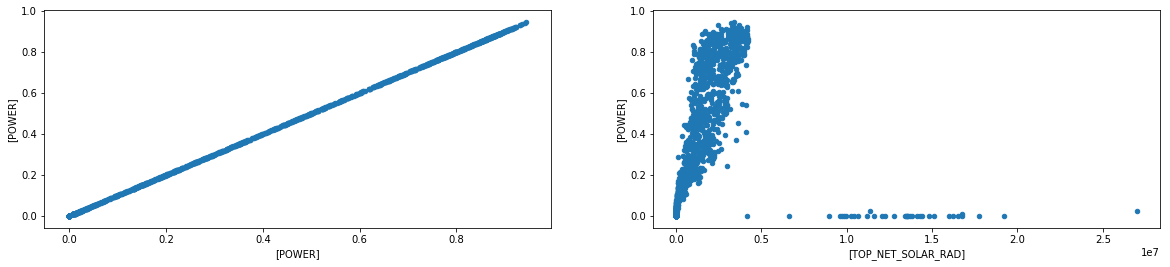

In [60]:
plot_scatters(df.sample(2000)[["POWER","TOP_NET_SOLAR_RAD","SOLAR_RAD"]],"POWER")

In [57]:
def plot_lags_and_auto(df):
    columns = len(df.columns)
    for col in df.columns:
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        fig.suptitle(col, fontsize=16)
        lag_plot(df[col].tail(250),ax =ax[0])
        autocorrelation_plot(df[col].tail(250), ax = ax[1])

In [ ]:
plot_lags_and_auto(df)

Innen azok a mezők használhatóak csak, amiknek 24 lag után is viszonylag erős autokorrelációjuk van.
Ezek pedig:
* Surface pressure
* Relative humidity
* WIND U
* WIND V
* Temperature

Ezek alapján amiket fel fogok használni featureként azok a surface pressure és a temperature. Illetve a célváltozót is.

In [ ]:
df_to_plot = df.drop(["SEASONAL","HOUR","MONTH","RESID","TREND"],axis=1).resample('D').mean()
fig, ax = plt.subplots(figsize=(14,8))         # Sample figsize in inches

f = (
    df_to_plot.loc[:, df_to_plot.columns]
        
).corr()

sns.heatmap(f, annot=True, ax=ax)

Később talán az esőt is beleveszem, illetve a felhőtakarót. 

Rolling apply segítségével létrehozom a mozgó átlagot 24 órás ablakra a fennt említett mezőkhöz.

In [ ]:
df_to_train = df[["POWER","SURFACE_PRESSURE","TEMPERATURE","HOUR","MONTH","SOLAR_RAD","RELATIVE_HUMIDITY"]]
df_to_train = df.drop(['RESID','SEASONAL','TREND','RT'],axis=1)
for column in ["POWER","SURFACE_PRESSURE","TEMPERATURE"]:
    rolling_column = df_to_train[column].rolling(window = 24)
    shift = 24
    df_to_train["ROLLING_MEAN_"+column] = rolling_column.mean().shift(shift)
    df_to_train["ROLLING_MAX_"+column] = rolling_column.max().shift(shift)
    df_to_train["ROLLING_SUM_"+column] = rolling_column.sum().shift(shift)
    df_to_train["ROLLING_MEDIAN_"+column] = rolling_column.median().shift(shift)
    df_to_train["ROLLING_STD_"+column] = rolling_column.std().shift(shift)
    df_to_train["ROLLING_VAR_"+column] = rolling_column.var().shift(shift)

for column in ["POWER","SURFACE_PRESSURE","TEMPERATURE"]:
    rolling_column = df_to_train[column].rolling(window = 48)
    shift = 24
    df_to_train["ROLLING_MEAN_"+column] = rolling_column.mean().shift(shift)
    df_to_train["ROLLING_MAX_"+column] = rolling_column.max().shift(shift)
    df_to_train["ROLLING_SUM_"+column] = rolling_column.sum().shift(shift)
    df_to_train["ROLLING_MEDIAN_"+column] = rolling_column.median().shift(shift)
    df_to_train["ROLLING_STD_"+column] = rolling_column.std().shift(shift)
    df_to_train["ROLLING_VAR_"+column] = rolling_column.var().shift(shift)
    
#["POWER","SURFACE_PRESSURE","TEMPERATURE"]
X_train = df_to_train[:ONE_MONTH].dropna(axis = 0).drop(["POWER"],axis=1)
y_train = df_to_train[:ONE_MONTH].dropna(axis = 0).POWER
X_test = df_to_train[ONE_YEAR:].dropna(axis = 0).drop(["POWER"],axis=1)
y_test = df_to_train[ONE_YEAR:].dropna(axis = 0).POWER

Először, a power-re predictelek, mert a szezonalitást még nem tudom hogy tároljam le.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

def train_predict_and_score_2(X_train, y_train,X_test,y_test,model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    
    return mean_squared_error(y_test,y_pred)

def evaluate_model(df,model):
    X = df[:ONE_YEAR].dropna(axis=0).drop("POWER",axis=1).values
    y = df[:ONE_YEAR].dropna(axis=0).POWER
    tscv = TimeSeriesSplit(n_splits=365,max_train_size=ONE_MONTH)
    #print(tscv)  
    MSEs = np.array(1)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        MSEs = np.append(MSEs,train_predict_and_score_2(X_train,y_train,X_test,y_test,model))
        #print("TRAIN:", len(train_index), "TEST:", len(test_index),"MSE:",train_predict_and_score_2(X_train,y_train,X_test,y_test,RandomForestRegressor()))
    return MSEs

def evaluate_models(df,models,names):
    model_scores = []
    for name,model in zip(names,models):
        model_scores.append(evaluate_model(df,model))
    fig, ax = plt.subplots(figsize=(10,5))
    for model_score in model_scores:
        plt.plot(model_score)

In [ ]:
def train_predict_and_score(X_train, y_train,X_test,y_test,models,names):
    fig, ax = plt.subplots(figsize=(10,5))
    y_plot = pd.DataFrame(y_test.values)
    y_plot = y_plot.rename(index=str, columns={0: "Original"})
    sns.kdeplot(y_plot["Original"])
    for name,model in zip(names,models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)    
        y_plot = pd.DataFrame(y_pred)
        y_plot = y_plot.rename(index=str, columns={0: name})
        sns.kdeplot(y_plot[name])
        print("{0}\nMSE:{1} | EVS:{2}".format(name,mean_squared_error(y_test,y_pred),explained_variance_score(y_test,y_pred)))

In [ ]:
names=["LinReg", "Lasso","Elastic Net"]
models = [LinearRegression(),Lasso(),ElasticNet()]
evaluate_models(df_to_train,models,names)
names=["XGBoost Linear", "XGBoost Tree","Ridge"]
models = [XGBRegressor(booster='gblinear'),XGBRegressor(),Ridge()]
evaluate_models(df_to_train,models,names)
names=["RandomForestRegressor","AdaBoostRegressor", "BaggingRegressor"]
models = [RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor()]
evaluate_models(df_to_train,models,names)

In [ ]:
y_train_baseline = df[:ONE_YEAR].dropna(axis=0)['POWER']
X_train_baseline = df[:ONE_YEAR].dropna(axis=0).drop(['POWER','RESID','SEASONAL','TREND','RT'],axis=1)
y_test_baseline = df[2*ONE_YEAR:].dropna(axis=0)['POWER']
X_test_baseline = df[2*ONE_YEAR:].dropna(axis=0).drop(['POWER','RESID','SEASONAL','TREND','RT'],axis=1)
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor
names=["RandomForestRegressor"]
models = [RandomForestRegressor()]
train_predict_and_score(X_train_baseline,y_train_baseline,X_test_baseline,y_test_baseline,models,names)

In [ ]:
from sklearn.model_selection import cross_val_score,TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [ ]:
clf = RandomForestRegressor()
clf.fit(X_train_baseline,y_train_baseline)
plotModelResults(clf,X_test=X_test_baseline,X_train=X_train_baseline,plot_intervals=True)

In [ ]:
y_train_baseline = df.copy()[:ONE_YEAR].dropna(axis=0)['RT']
X_train_baseline = df.copy()[:ONE_YEAR].dropna(axis=0).drop(['POWER','RESID','SEASONAL','TREND','RT'],axis=1)
y_test_baseline = df.copy()[ONE_YEAR:].dropna(axis=0)['RT']
X_test_baseline = df.copy()[ONE_YEAR:].dropna(axis=0).drop(['POWER','RESID','SEASONAL','TREND','RT'],axis=1)
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor
names=["RandomForestRegressor"]
models = [RandomForestRegressor()]
train_predict_and_score(X_train,y_train,X_test,y_test,models,names)

In [ ]:
names=["LinReg", "Lasso","Elastic Net"]
models = [LinearRegression(),Lasso(),ElasticNet()]
train_predict_and_score(X_train,y_train,X_test,y_test,models,names)
names=["XGBoost Linear", "XGBoost Tree","Ridge"]
models = [XGBRegressor(booster='gblinear'),XGBRegressor(),Ridge()]
train_predict_and_score(X_train,y_train,X_test,y_test,models,names)
names=["RandomForestRegressor","AdaBoostRegressor", "BaggingRegressor"]
models = [RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor()]
train_predict_and_score(X_train,y_train,X_test,y_test,models,names)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,explained_variance_score
pd.options.mode.chained_assignment = None

def train_predict(X_train, y_train,X_test,y_test,model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def evaluate_model(df,model,name,columns=["POWER","SURFACE_PRESSURE","TEMPERATURE"],windows=[ONE_DAY,2*ONE_DAY],step=ONE_DAY,size=ONE_MONTH):
    for column,window in zip(columns,windows):
        rolling_column = df[column].rolling(window = window)
        df["ROLLING_MEAN_"+column+"_"+str(window)] = rolling_column.mean().shift(step)
        df["ROLLING_MAX_"+column+"_"+str(window)] = rolling_column.max().shift(step)
        df["ROLLING_SUM_"+column+"_"+str(window)] = rolling_column.sum().shift(step)
        df["ROLLING_MEDIAN_"+column+"_"+str(window)] = rolling_column.median().shift(step)
        df["ROLLING_STD_"+column+"_"+str(window)] = rolling_column.std().shift(step)
        df["ROLLING_VAR_"+column+"_"+str(window)] = rolling_column.var().shift(step)
    
    X = df[:size].dropna(axis=0).drop("POWER",axis=1).values
    y = df[:size].dropna(axis=0).POWER
    
    tscv = TimeSeriesSplit(n_splits=int(size/step))
    #print(tscv)  
    y_preds = np.array(1)
    y_tests = np.array(1)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_preds = np.append(y_preds,train_predict(X_train,y_train,X_test,y_test,model))
        y_tests = np.append(y_tests,y_test.values)
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(y_tests)
    ax.plot(y_preds)
    ax.set_title(name)
    return explained_variance_score(y_preds,y_tests)

def evaluate_models(df,models,names):
    model_scores = []
    for name,model in zip(names,models):
        model_scores.append(evaluate_model(df,model,name))
    return dict(zip(names, model_scores))

def do_all(df,models,names):
    for i in range(1,4):
        #df_to_train = df[df["ZONEID"] == i].drop('ZONEID',axis=1)
        df_to_train = df
        evaluate_models(df_to_train,models,names)
        results = evaluate_models(df_to_train,models,names)
        #fig,ax = plt.subplots(figsize=(20,5))
        #results.boxplot(ax=ax, showfliers=False)
        print("| Zone:{0} | {1} |".format(i,results))

In [ ]:
df_to_train.columns

In [ ]:
names=["LinReg", "Lasso","Elastic Net"]
models = [LinearRegression(),Lasso(),ElasticNet()]
do_all(df_to_train,models,names)
names=["XGBoost Linear", "XGBoost Tree","Ridge"]
models = [XGBRegressor(booster='gblinear'),XGBRegressor(),Ridge()]
do_all(df_to_train,models,names)
names=["RandomForestRegressor","AdaBoostRegressor", "BaggingRegressor"]
models = [RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor()]
do_all(df_to_train,models,names)

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pylab as plt
import pandas as pd, numpy as np
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

def xgb_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

def objective(space):

    clf = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = space['max_depth'],
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:linear',
                           nthread=8
                           )

    eval_set  = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train,
            y_train,
            eval_set=eval_set,
            eval_metric = 'mae')

    pred = clf.predict(X_test)
#   mae = mean_absolute_error(np.exp(y_valid), np.exp(pred))
    mae = mean_absolute_error((y_test), (pred))

    print("SCORE:", mae)
    return{'loss':mae, 'status': STATUS_OK }


space ={
        'max_depth': hp.choice('max_depth', np.arange(10, 30, dtype=int)),
        'min_child_weight': hp.quniform ('min_child', 1, 20, 1),
        'subsample': hp.uniform ('subsample', 0.8, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(1000, 10000, 100, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

# space ={
#         'max_depth': hp.choice('max_depth', np.arange(10, 11, dtype=int)),
#         'min_child_weight': hp.quniform ('min_child', 1,2,1),
#         'subsample': hp.uniform ('subsample', 0.8,1),
#         'n_estimators' : hp.choice('n_estimators', np.arange(100, 1000, 10, dtype=int)),
#         'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
#         'gamma' : hp.quniform('gamma', 0.5, 1, 0.5),
#         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5,1, 0.5)
#        }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=3, # change
            trials=trials)

print(best)

Ez alapján az XGBoost tűnik a leghatékonyabbnak.

## Amit lehetné még meg kell csinálni/javítani kell: 
* Megcsinálni a többi zónára is
* Jobb Feature selection
* Algoritmusok paraméterezése
* Tényleg csak a residual-t predictelni és összeadni a seasonality-vel
* A napsugárzás változóból kidobálni az outliereket és felhasználni
* Más rolling window értékek kipróbálása. Bár szerintem 48 óránál nagyobb nem nagyon jön szóba.
* ARIMA modell implementálása

## Konzultáció
* Írjam le miért kell a kauzalitást őrizni
* Baseline modell összehasonlításhoz
* Mérnöki döntések, mit, miért, milyen döntések mentén
* Megoldás erősségei, gyengeségei, továbbfejlesztési lehetőségei (paraméter optimalizálás esetleg, jobb feature selection)
* Továbblépési lehetőségek: milyen külső adathalmazt lehetne bekötni.
* Predictors az előrejelzés, nem mért adat.
* Ötlet: karakterisztikát kell
* Érdemes lineárisra hozni az összefüggéseket
* Meteorológia adatok forecastok.
* Diploma terv portált, latex, megnézni
* Prezi struktúrában ugyanaz, de inkább overview

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,explained_variance_score
pd.options.mode.chained_assignment = None

def train_predict(X_train, y_train,X_test,y_test,model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def evaluate_model(df,model,name,columns=['POWER'],windows=[ONE_DAY,2*ONE_DAY],step=ONE_DAY,size=ONE_MONTH):    
    X = df[:size].dropna(axis=0).drop("POWER",axis=1).values
    y = df[:size].dropna(axis=0).POWER
    
    tscv = TimeSeriesSplit(n_splits=int(size/step),max_train_size=size)
    #print(tscv)  
    y_preds = np.array(1)
    y_tests = np.array(1)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_preds = np.append(y_preds,train_predict(X_train,y_train,X_test,y_test,model))
        y_tests = np.append(y_tests,y_test.values)
        #print("TRAIN:", len(train_index), "TEST:", len(test_index),"MSE:",train_predict_and_score_2(X_train,y_train,X_test,y_test,RandomForestRegressor()))
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(y_tests)
    ax.plot(y_preds)
    ax.set_title(name)
    return explained_variance_score(y_preds,y_tests)

def evaluate_models(df,models,names):
    model_scores = []
    for name,model in zip(names,models):
        model_scores.append(evaluate_model(df,model,name))
    return dict(zip(names, model_scores))
#return pd.DataFrame.from_dict(dict(zip(names, model_scores)))

In [ ]:
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge,SGDRegressor
from xgboost import XGBRegressor

def do_all(df,models,names):
    for i in range(1,4):
        df_to_train = df[df["ZONEID"] == i].drop('ZONEID',axis=1)
        evaluate_models(df_to_train,models,names)
        results = evaluate_models(df_to_train,models,names)
        #fig,ax = plt.subplots(figsize=(20,5))
        #results.boxplot(ax=ax, showfliers=False)
        print("| Zone:{0} | {1} |".format(i,results))

In [ ]:
#names=["LinReg", "Lasso","Elastic Net","XGBoost Linear","Ridge","SGDRegressor"]
#models = [LinearRegression(),Lasso(),ElasticNet(),XGBRegressor(booster='gblinear'),Ridge(),SGDRegressor()]
names=["XGBoost Tree","RandomForestRegressor","AdaBoostRegressor", "BaggingRegressor"]
models = [XGBRegressor(nthread=4),RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor()]
do_all(df,models,names)